<a href="https://colab.research.google.com/github/predorama/nordal/blob/main/Nordal_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# URL файла в Google Drive
url = 'https://drive.google.com/uc?id=1fCdkrVc5KW50bNYamw73YWI0bVUiNtkz'
# Локальный путь для сохранения файла
output = 'merged_data.csv'
# Загрузка файла
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1fCdkrVc5KW50bNYamw73YWI0bVUiNtkz
To: /content/merged_data.csv
100%|██████████| 1.46M/1.46M [00:00<00:00, 35.5MB/s]


'merged_data.csv'

In [ ]:
# Загрузка val
URL = 'http://www.garant-don.ru/adept/DOC/data_val.csv'
download_filename = gdown.download(URL, None, quiet = True)

In [ ]:
df = pd.read_csv('merged_data.csv')
df.head()

,Timestamp,PT,TT,VT-1,VT-2,VT-3
0,2023-09-05T18:07:39.291,0.098980,19.892927,2.979729,1.684748,3.298897
1,2023-09-05T18:08:51.181,0.098980,19.892927,2.979729,1.684748,3.298897
2,2023-09-05T18:25:53.301,0.130042,19.763473,2.733892,1.587965,3.051841
3,2023-09-05T18:27:05.157,0.130042,19.763473,2.733892,1.587965,3.051841
4,2023-09-05T19:12:03.217,0.094240,19.024090,3.022907,1.749984,3.338387


In [ ]:
df.describe()

,PT,TT,VT-1,VT-2,VT-3
count,18056.000000,18036.000000,18051.000000,18054.000000,18056.000000
mean,0.415203,16.984071,2.542142,1.888916,2.687193
std,0.587031,3.657324,0.834369,1.017797,0.722979
min,0.000000,0.000000,-0.107930,-0.005616,-0.166988
25%,0.074734,15.166408,1.624551,1.466545,2.043868
50%,0.107588,17.251796,2.803261,2.165789,2.160749
75%,0.217366,19.581638,3.216241,2.656433,3.397575
max,2.437521,24.886782,4.410582,4.008006,4.615355


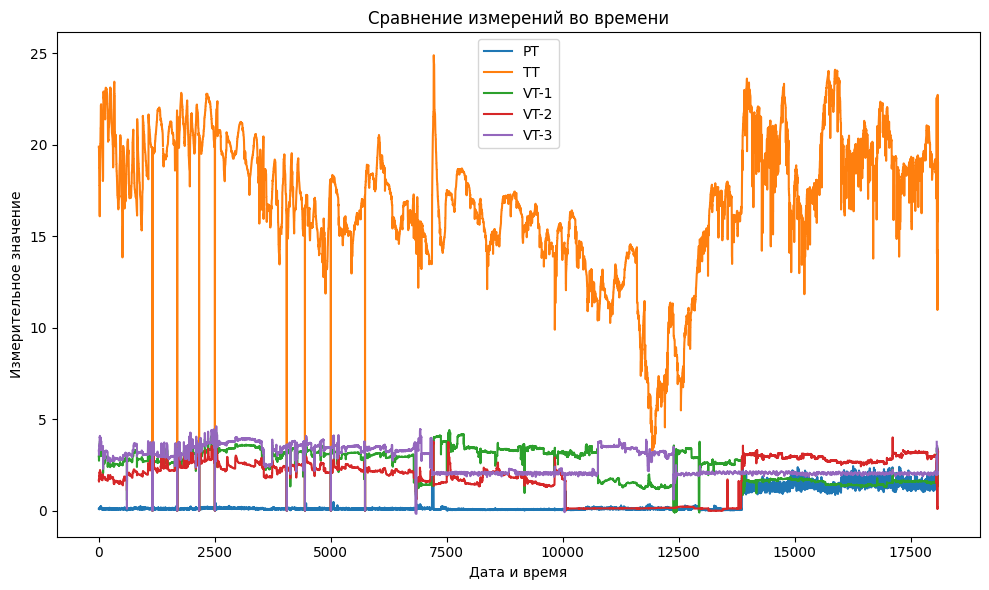

In [ ]:
# Создание фигуры и установка её размера
fig, ax = plt.subplots(figsize=(10, 6))

# Построение линии для каждого столбца
for column in ['PT', 'TT', 'VT-1', 'VT-2', 'VT-3']:
    df[column].plot(ax=ax, label=column)

# Настройка осей и заголовков
plt.title('Сравнение измерений во времени')
plt.xlabel('Дата и время')
plt.ylabel('Измерительное значение')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

In [ ]:
# Загрузка набора данных
file_path = 'merged_data.csv'  # Замените на фактический путь к вашему файлу с данными
df = pd.read_csv(file_path)

# Предполагая, что столбец с временными метками называется 'Timestamp', вы можете исключить его
# При необходимости отрегулируйте название столбца
sensor_columns = df.columns.difference(['Timestamp'])

# Выберите только числовые столбцы, исключая столбец с временными метками
numeric_df = df[sensor_columns].select_dtypes(include=['number'])

# Найдите максимальное значение и индекс для каждого датчика
max_values = numeric_df.max()
max_indices = numeric_df.idxmax()

# Отобразите результаты
print("Максимальные значения для каждого датчика:")
print(max_values)
print("\nИндексы максимальных значений для каждого датчика:")
print(max_indices)


Maximum Values for Each Sensor:
PT       2.437521
TT      24.886782
VT-1     4.410582
VT-2     4.008006
VT-3     4.615355
dtype: float64

Indices of Maximum Values for Each Sensor:
PT      16256
TT       7218
VT-1     7554
VT-2    17109
VT-3     2530
dtype: int64


Шаг 1: Предобработка данных

In [ ]:
# Загрузка набора данных
file_path = 'merged_data.csv'
df = pd.read_csv(file_path)

# Предполагаем, что столбец с метками времени называется 'Timestamp'
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Обработка пропущенных значений (например, заполнение предыдущими значениями)
df.fillna(method='ffill', inplace=True)

# Выбор столбцов с датчиками для обучения
sensor_columns = df.columns.difference(['Timestamp'])
sensor_data = df[sensor_columns]

# Нормализация данных
scaler = MinMaxScaler()
sensor_data_normalized = scaler.fit_transform(sensor_data)

# Создание входных признаков и меток
# Для предсказательного обслуживания можно использовать окно прошлых данных для предсказания будущих значений
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequence = data[i:i + window_size]
        label = data[i + window_size]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

window_size = 50  # Пример размера окна
X, y = create_sequences(sensor_data_normalized, window_size)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Шаг 2: Выбор и обучение модели

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Определение модели
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    Dense(X_train.shape[2])
])

# Компиляция модели
model.compile(optimizer='adam', loss='mse')

# Обучение модели
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
361/361 [==============================] - 11s 19ms/step - loss: 0.0274 - val_loss: 0.0035
Epoch 2/50
361/361 [==============================] - 6s 18ms/step - loss: 0.0089 - val_loss: 0.0021
Epoch 3/50
361/361 [==============================] - 6s 18ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 4/50
361/361 [==============================] - 7s 18ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 5/50
361/361 [==============================] - 6s 18ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 6/50
361/361 [==============================] - 6s 18ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 7/50
361/361 [==============================] - 7s 18ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 8/50
361/361 [==============================] - 6s 18ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 9/50
361/361 [==============================] - 7s 19ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 10/50
361/361 [==============================] - 7s 19ms/step - loss: 0.0038 - val_l

Шаг 3: Оценка модели

113/113 [==============================] - 1s 6ms/step - loss: 0.0012
Тестовая потеря: 0.0011995736276730895
113/113 [==============================] - 1s 6ms/step


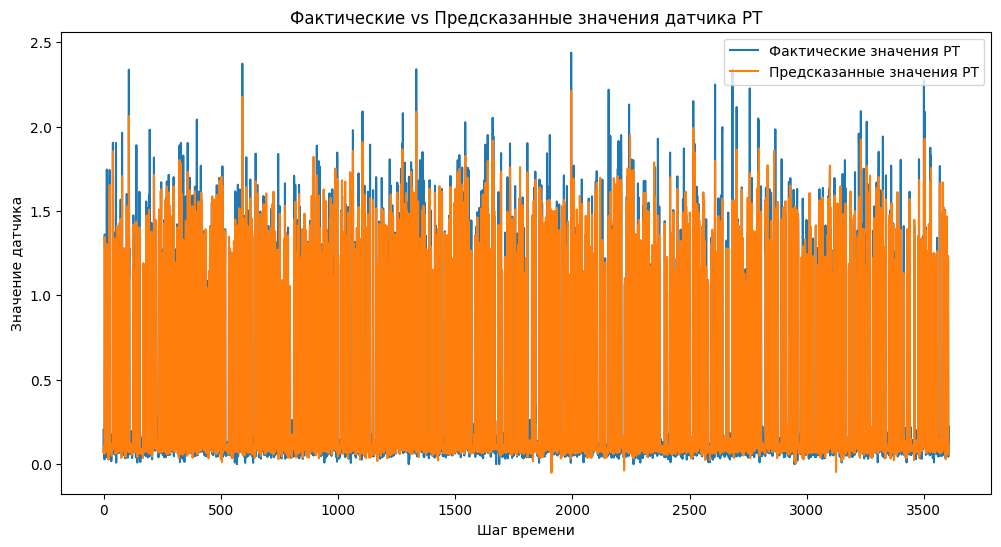

In [ ]:
# Оценка модели
loss = model.evaluate(X_test, y_test)
print(f'Тестовая потеря: {loss}')

# Предсказание на тестовом наборе
y_pred = model.predict(X_test)

# Обратное преобразование предсказанных и фактических значений (если необходимо)
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

# Сравнение предсказанных значений с фактическими
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse[:, 0], label='Фактические значения PT')
plt.plot(y_pred_inverse[:, 0], label='Предсказанные значения PT')
plt.title('Фактические vs Предсказанные значения датчика PT')
plt.xlabel('Шаг времени')
plt.ylabel('Значение датчика')
plt.legend()
plt.show()


In [ ]:
# Выбор столбцов с датчиками для обучения
sensor_columns = df.columns.difference(['Timestamp'])
sensor_data = df[sensor_columns]

# Нормализация данных
scaler = MinMaxScaler()
sensor_data_normalized = scaler.fit_transform(sensor_data)

# Создание входных признаков и меток
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequence = data[i:i + window_size]
        label = data[i + window_size]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

window_size = 50
X, y = create_sequences(sensor_data_normalized, window_size)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.optimizers import Adam
# Определение модели
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(X_train.shape[2])
])

# Компиляция модели с оптимизатором Adam и learning rate = 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Обучение модели с валидацией
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
361/361 [==============================] - 21s 47ms/step - loss: 0.0234 - val_loss: 0.0033
Epoch 2/50
361/361 [==============================] - 17s 47ms/step - loss: 0.0081 - val_loss: 0.0026
Epoch 3/50
361/361 [==============================] - 17s 47ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 4/50
361/361 [==============================] - 17s 48ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 5/50
361/361 [==============================] - 17s 47ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 6/50
361/361 [==============================] - 17s 48ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 7/50
361/361 [==============================] - 17s 47ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 8/50
361/361 [==============================] - 17s 46ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 9/50
361/361 [==============================] - 17s 46ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 10/50
361/361 [==============================] - 17s 47ms/step - loss: 0.003

In [ ]:
# Сохранение модели
model.save('trained_model.h5')

In [ ]:
# Оценка модели на тестовых данных
loss = model.evaluate(X_test, y_test)
print(f'Тестовая потеря: {loss}')

# Предсказание на тестовом наборе
y_pred = model.predict(X_test)

# Обратное преобразование предсказанных и фактических значений
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

113/113 [==============================] - 2s 16ms/step - loss: 0.0020
Тестовая потеря: 0.001982212532311678
113/113 [==============================] - 2s 15ms/step


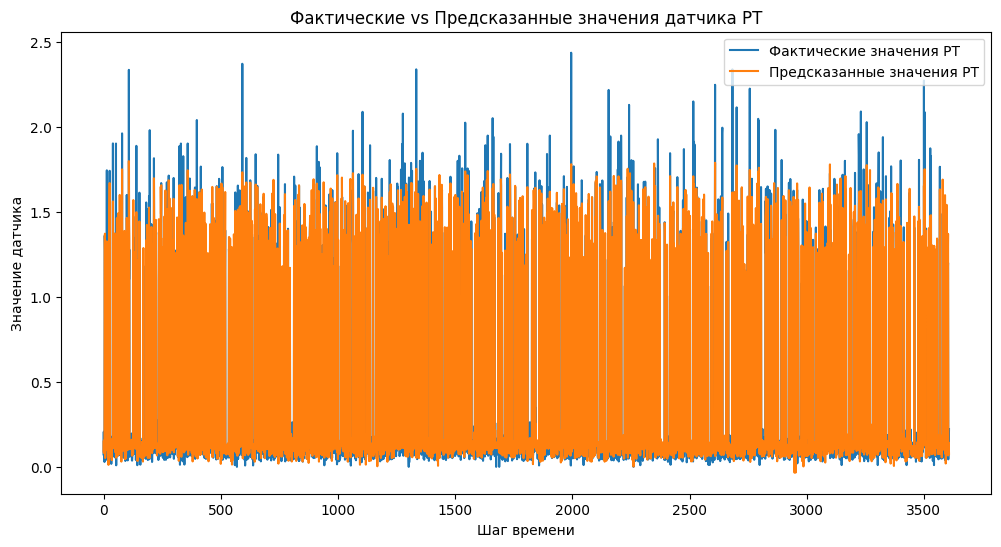

In [ ]:
# Сравнение предсказанных значений с фактическими
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse[:, 0], label='Фактические значения PT')
plt.plot(y_pred_inverse[:, 0], label='Предсказанные значения PT')
plt.title('Фактические vs Предсказанные значения датчика PT')
plt.xlabel('Шаг времени')
plt.ylabel('Значение датчика')
plt.legend()
plt.show()

#Валидация на другом наборе данных

In [ ]:
data = pd.read_csv('data_val.csv')
data

,data,PT,TT,VT-1,VT-2,VT-3
0,2023-09-14 00:00:00,0.076393,20.505867,0.044143,1.126706,0.493701
1,2023-09-14 00:00:01,0.074195,20.506470,0.049663,1.955037,0.932823
2,2023-09-14 00:00:02,0.073417,20.507673,0.043737,1.456546,0.872463
3,2023-09-14 00:00:03,0.074811,20.506470,0.042059,1.131358,0.907374
4,2023-09-14 00:00:04,0.072613,20.507072,0.040199,0.868154,1.235200
...,...,...,...,...,...,...
12763,2023-09-14 08:59:54,0.067869,23.729229,0.040017,0.469468,0.464943
12764,2023-09-14 08:59:56,0.069692,23.729832,0.050890,0.522995,0.604004
12765,2023-09-14 08:59:57,0.066529,23.728626,0.047867,0.556221,0.890807
12766,2023-09-14 08:59:58,0.066609,23.729832,0.050124,0.447651,0.634568


In [ ]:
data.describe()

,PT,TT,VT-1,VT-2,VT-3
count,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000
mean,0.069501,21.121824,0.043361,1.034049,0.820480
std,0.002968,1.208758,0.007430,1.305744,0.416749
min,0.057416,19.668709,0.023461,0.159371,0.170406
25%,0.067306,20.128845,0.038143,0.794431,0.600053
50%,0.069317,20.626925,0.042456,1.005850,0.766863
75%,0.071729,21.990469,0.047617,1.223321,0.985888
max,0.079046,23.731035,0.086888,136.643387,29.989769


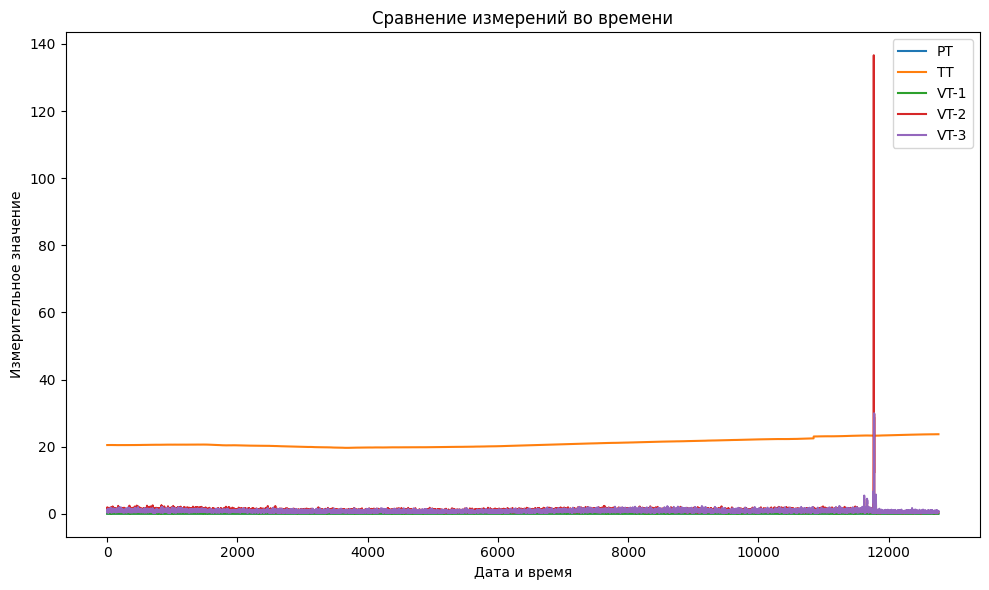

In [ ]:
# Создание фигуры и установка её размера
fig, ax = plt.subplots(figsize=(10, 6))

# Построение линии для каждого столбца
for column in ['PT', 'TT', 'VT-1', 'VT-2', 'VT-3']:
    data[column].plot(ax=ax, label=column)

# Настройка осей и заголовков
plt.title('Сравнение измерений во времени')
plt.xlabel('Дата и время')
plt.ylabel('Измерительное значение')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

In [ ]:
# Загрузка данных для валидации
val_file_path = 'data_val.csv'
df_val = pd.read_csv(val_file_path)

# Предполагается, что 'Timestamp' является временным столбцом
df_val['Timestamp'] = pd.to_datetime(df_val['data'])
df_val.set_index('data', inplace=True)

# Заполнение пропущенных значений
df_val.fillna(method='ffill', inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# использование того же нормализатора, что и для обучающих данных
sensor_columns = ['PT', 'TT', 'VT-1', 'VT-2', 'VT-3']
sensor_data_val = df_val[sensor_columns]

# Нормализация данных (fit_transform для обеспечения согласованного масштабирования)
scaler = MinMaxScaler()
sensor_data_normalized_val = scaler.fit_transform(sensor_data_val)

# Отображение нормализованных данных
pd.DataFrame(sensor_data_normalized_val, columns=sensor_columns).head()


,PT,TT,VT-1,VT-2,VT-3
0,0.877326,0.206079,0.326074,0.007088,0.010842
1,0.775714,0.206227,0.413112,0.013157,0.025568
2,0.739774,0.206523,0.319675,0.009504,0.023544
3,0.804215,0.206227,0.293218,0.007122,0.024714
4,0.702602,0.206375,0.263900,0.005193,0.035708


In [ ]:
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequence = data[i:i + window_size]
        label = data[i + window_size]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

window_size = 50  # Пример размера окна
X_val, y_val = create_sequences(sensor_data_normalized_val, window_size)

# Отображение форм последовательностей
X_val.shape, y_val.shape


((12718, 50, 5), (12718, 5))

In [ ]:
from tensorflow.keras.models import load_model

# Загрузка обученной модели
model = load_model('trained_model.h5')  # Adjust the path if needed

# Отображение сводки модели
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 100)           42400     
                                                                 
 dropout_3 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_4 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 72855 (284.59 KB)
Trainable params: 72855 (284.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Прогнозирование с использованием обученной модели
y_pred_val = model.predict(X_val)

# Обратное преобразование предсказанных и фактических значений
y_val_inverse = scaler.inverse_transform(y_val)
y_pred_inverse_val = scaler.inverse_transform(y_pred_val)

# Отображение форм обратных преобразованных значений
y_val_inverse.shape, y_pred_inverse_val.shape


398/398 [==============================] - 9s 21ms/step


((12718, 5), (12718, 5))

In [ ]:
# Оценка модели на валидационном наборе данных
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


398/398 [==============================] - 9s 19ms/step - loss: 0.0842
Validation Loss: 0.08416804671287537


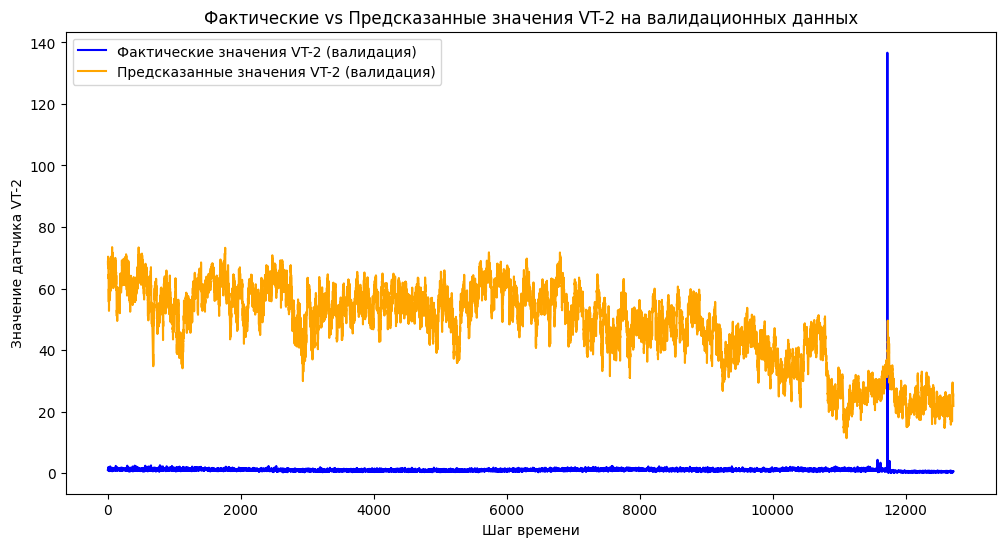

In [ ]:
# Визуализация фактических и предсказанных значений VT-2 на валидационных данных
plt.figure(figsize=(12, 6))
plt.plot(y_val_inverse[:, sensor_columns.index('VT-2')], label='Фактические значения VT-2 (валидация)', color='blue')
plt.plot(y_pred_inverse_val[:, sensor_columns.index('VT-2')], label='Предсказанные значения VT-2 (валидация)', color='orange')
plt.title('Фактические vs Предсказанные значения VT-2 на валидационных данных')
plt.xlabel('Шаг времени')
plt.ylabel('Значение датчика VT-2')
plt.legend()
plt.show()


#Удаление выбросов

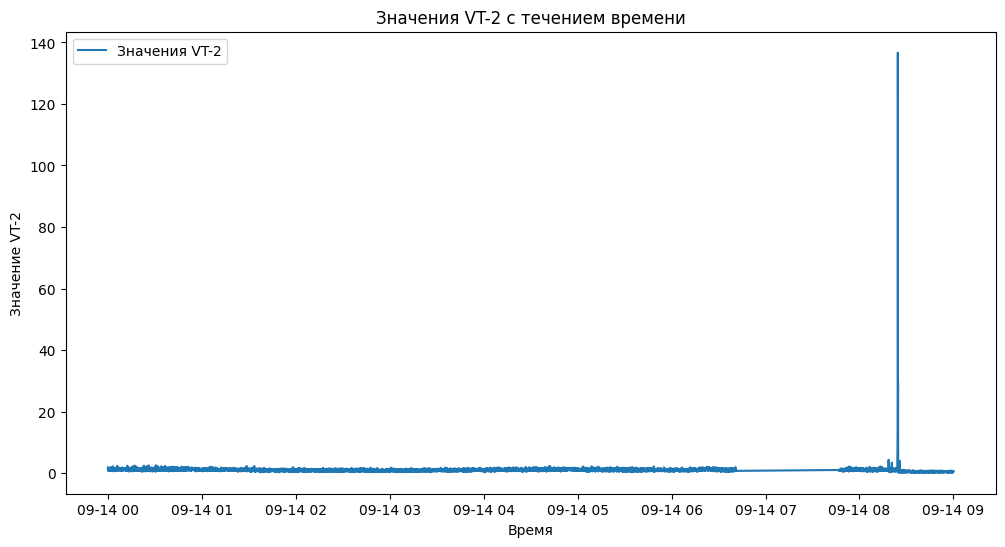

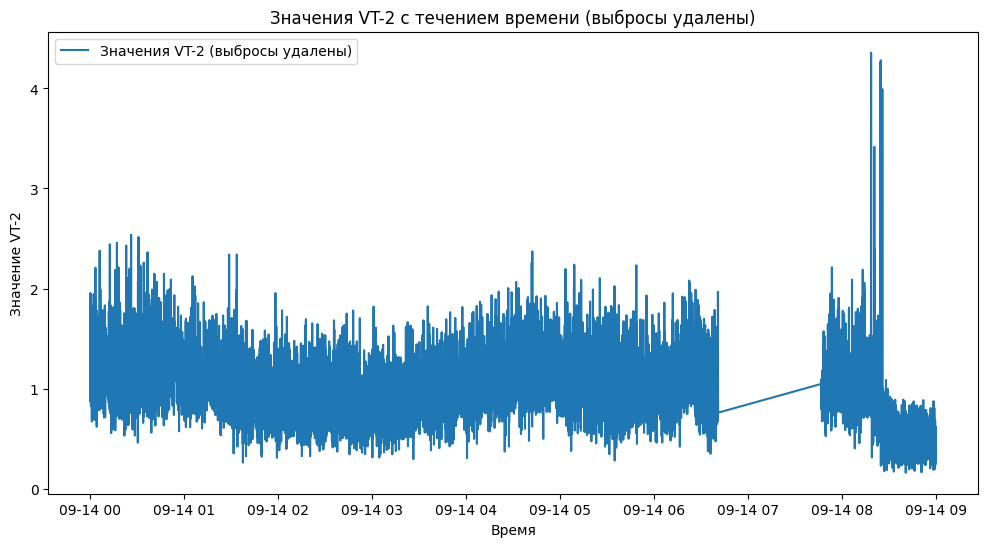

In [ ]:
# Загрузка данных для валидации
val_file_path = 'data_val.csv'
df_val = pd.read_csv(val_file_path)

# Предполагается, что 'Timestamp' является временным столбцом
df_val['Timestamp'] = pd.to_datetime(df_val['Timestamp'])
df_val.set_index('Timestamp', inplace=True)

# Заполнение пропущенных значений
df_val.fillna(method='ffill', inplace=True)

# Построение графика VT-2 для идентификации выбросов
plt.figure(figsize=(12, 6))
plt.plot(df_val.index, df_val['VT-2'], label='Значения VT-2')
plt.title('Значения VT-2 с течением времени')
plt.xlabel('Время')
plt.ylabel('Значение VT-2')
plt.legend()
plt.show()

# Удаление выбросов из VT-2 (значения за пределами 3 стандартных отклонений от среднего)
mean_vt2 = df_val['VT-2'].mean()
std_vt2 = df_val['VT-2'].std()
outlier_threshold = 3 * std_vt2
df_val['VT-2'] = np.where(
    np.abs(df_val['VT-2'] - mean_vt2) > outlier_threshold,
    mean_vt2,
    df_val['VT-2']
)

# Построение графика VT-2 после удаления выбросов
plt.figure(figsize=(12, 6))
plt.plot(df_val.index, df_val['VT-2'], label='Значения VT-2 (выбросы удалены)')
plt.title('Значения VT-2 с течением времени (выбросы удалены)')
plt.xlabel('Время')
plt.ylabel('Значение VT-2')
plt.legend()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# использование того же нормализатора, что и для обучающих данных
sensor_columns = ['PT', 'TT', 'VT-1', 'VT-2', 'VT-3']
sensor_data_val = df_val[sensor_columns]

# Нормализация данных (fit_transform для обеспечения согласованного масштабирования)
scaler = MinMaxScaler()
sensor_data_normalized_val = scaler.fit_transform(sensor_data_val)

# Отображение нормализованных данных
pd.DataFrame(sensor_data_normalized_val, columns=sensor_columns).head()


,PT,TT,VT-1,VT-2,VT-3
0,0.877326,0.206079,0.326074,0.230468,0.010842
1,0.775714,0.206227,0.413112,0.427818,0.025568
2,0.739774,0.206523,0.319675,0.309053,0.023544
3,0.804215,0.206227,0.293218,0.231576,0.024714
4,0.702602,0.206375,0.263900,0.168868,0.035708


In [ ]:
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequence = data[i:i + window_size]
        label = data[i + window_size]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

window_size = 50  # Пример размера окна
X_val, y_val = create_sequences(sensor_data_normalized_val, window_size)

# Отображение форм последовательностей
X_val.shape, y_val.shape


((12718, 50, 5), (12718, 5))

In [ ]:
from tensorflow.keras.models import load_model

# Загрузка обученной модели
model = load_model('trained_model.h5')  # Adjust the path if needed

# Отображение сводки модели
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 100)           42400     
                                                                 
 dropout_3 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_4 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 72,855
Trainable params: 72,855
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Прогнозирование с использованием обученной модели
y_pred_val = model.predict(X_val)

# Обратное преобразование предсказанных и фактических значений
y_val_inverse = scaler.inverse_transform(y_val)
y_pred_inverse_val = scaler.inverse_transform(y_pred_val)

# Отображение форм обратных преобразованных значений
y_val_inverse.shape, y_pred_inverse_val.shape


398/398 [==============================] - 7s 16ms/step


((12718, 5), (12718, 5))

In [ ]:
# Оценка модели на валидационном наборе данных
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


398/398 [==============================] - 7s 15ms/step - loss: 0.0652
Validation Loss: 0.06524021923542023


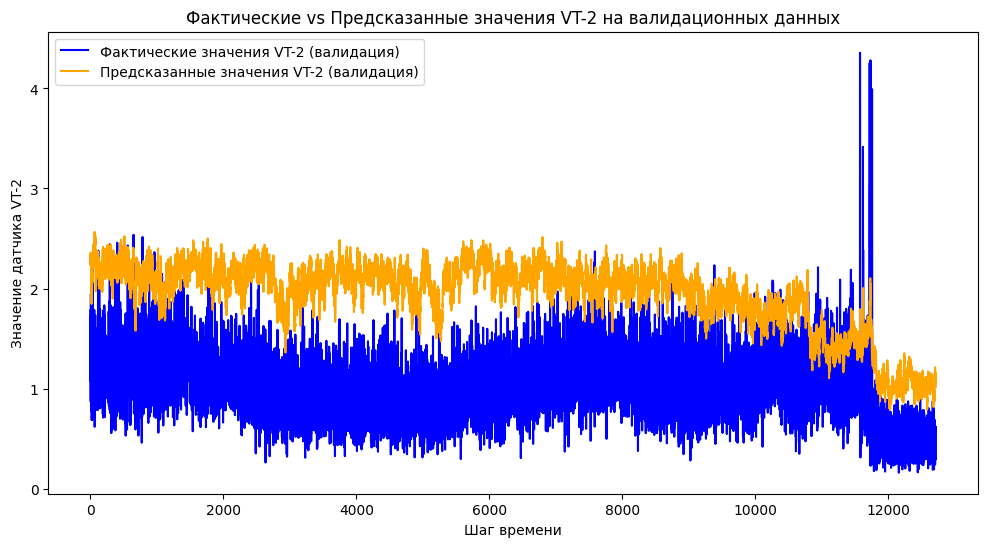

In [ ]:
# Визуализация фактических и предсказанных значений VT-2 на валидационных данных
plt.figure(figsize=(12, 6))
plt.plot(y_val_inverse[:, sensor_columns.index('VT-2')], label='Фактические значения VT-2 (валидация)', color='blue')
plt.plot(y_pred_inverse_val[:, sensor_columns.index('VT-2')], label='Предсказанные значения VT-2 (валидация)', color='orange')
plt.title('Фактические vs Предсказанные значения VT-2 на валидационных данных')
plt.xlabel('Шаг времени')
plt.ylabel('Значение датчика VT-2')
plt.legend()
plt.show()


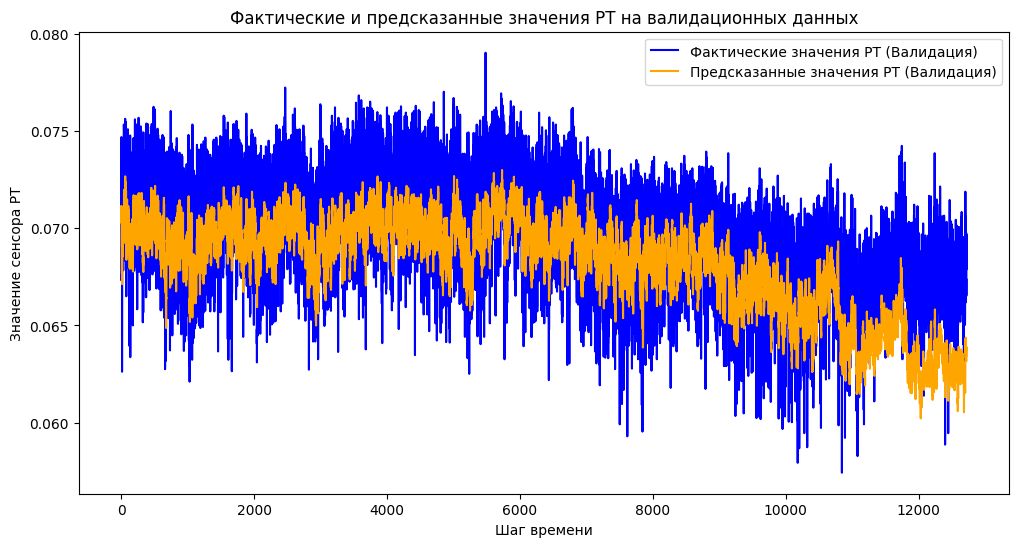

In [ ]:
# Визуализация фактических и предсказанных значений PT на валидационных данных
plt.figure(figsize=(12, 6))
plt.plot(y_val_inverse[:, sensor_columns.index('PT')], label='Фактические значения PT (Валидация)', color='blue')
plt.plot(y_pred_inverse_val[:, sensor_columns.index('PT')], label='Предсказанные значения PT (Валидация)', color='orange')
plt.title('Фактические и предсказанные значения PT на валидационных данных')
plt.xlabel('Шаг времени')
plt.ylabel('Значение сенсора PT')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Загрузка моделей
model_1 = load_model('saved_model.h5')
model_2 = load_model('trained_model.h5')

# Загрузка данных для масштабирования (например, data_train.csv)
train_data = pd.read_csv('merged_data.csv')
train_data.drop(columns=['Timestamp'], inplace=True)  # Удаление столбца Timestamp

# Создание и обучение масштабировщика
scaler = MinMaxScaler()
scaler.fit(train_data)

# Функция для предварительной обработки данных
def preprocess_data(data, window_size):
    # Преобразование данных в DataFrame
    df = pd.DataFrame(data)
    # Заполнение пропущенных значений
    df.fillna(method='ffill', inplace=True)
    # Нормализация данных
    data_normalized = scaler.transform(df)
    # Создание последовательностей
    sequences = []
    for i in range(len(data_normalized) - window_size):
        sequences.append(data_normalized[i:i + window_size])
    sequences = np.array(sequences)
    return sequences

# Функция для прогнозирования на будущие данные
def predict_future(data, model, window_size, future_steps):
    sequences = preprocess_data(data, window_size)
    predictions = []

    current_sequence = sequences[-1]  # Используем последнюю последовательность для начала прогнозирования

    for _ in range(future_steps):
        predicted = model.predict(current_sequence[np.newaxis, :, :])[0]
        predictions.append(predicted)
        current_sequence = np.append(current_sequence[1:], [predicted], axis=0)  # Обновляем последовательность

    predictions_inverse = scaler.inverse_transform(predictions)
    return predictions_inverse

# Пример использования функции
data_val = pd.read_csv('data_val.csv')
data_val.drop(columns=['Timestamp'], inplace=True)

future_steps = 10  # Количество шагов для прогнозирования в будущее

# Выбор модели для прогнозирования
model = model_1  # Или model_2

predicted_values = predict_future(data_val, model, window_size=50, future_steps=future_steps)

print(predicted_values)


1/1 [==============================] - 0s 25ms/step
[[ 0.05913293 19.9981711   0.81288675  0.53983837  1.58033723]
 [ 0.13459589 19.9961641   1.14065636  0.60293087  1.87567509]
 [ 0.17959206 19.82924666  1.35172217  0.62642199  2.06908013]
 [ 0.20790182 19.69933183  1.52939554  0.62212206  2.22044929]
 [ 0.22317848 19.59793622  1.67281005  0.5994268   2.33062219]
 [ 0.22869807 19.51343914  1.77811989  0.57069684  2.40959896]
 [ 0.22680931 19.42073607  1.85051897  0.5402971   2.46069842]
 [ 0.22008316 19.29888779  1.89532537  0.50887184  2.48803441]
 [ 0.21018768 19.14344717  1.91983065  0.47576832  2.49661498]
 [ 0.19868201 18.95701899  1.93091725  0.44061794  2.49030284]]


1/1 [==============================] - 0s 26ms/step


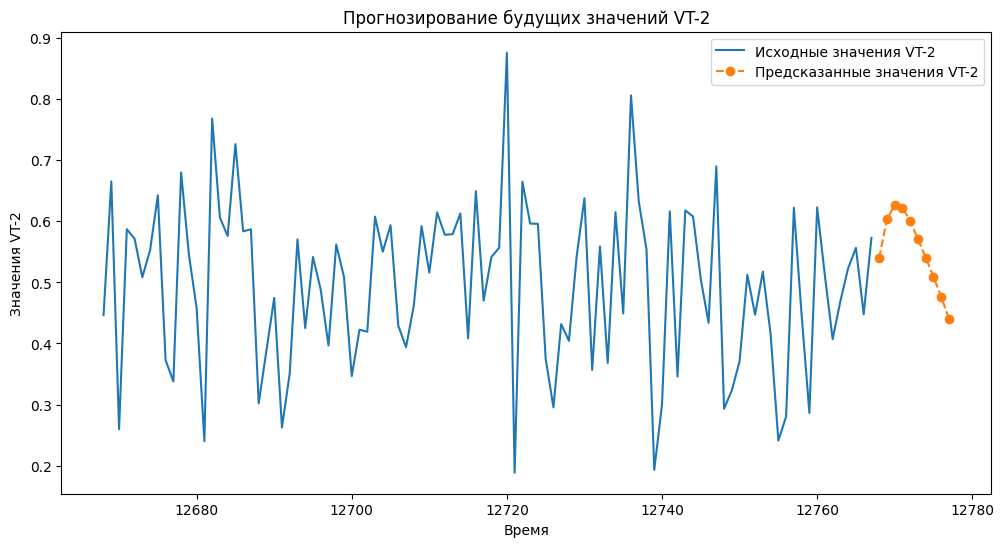

[[ 0.05913293 19.9981711   0.81288675  0.53983837  1.58033723]
 [ 0.13459589 19.9961641   1.14065636  0.60293087  1.87567509]
 [ 0.17959206 19.82924666  1.35172217  0.62642199  2.06908013]
 [ 0.20790182 19.69933183  1.52939554  0.62212206  2.22044929]
 [ 0.22317848 19.59793622  1.67281005  0.5994268   2.33062219]
 [ 0.22869807 19.51343914  1.77811989  0.57069684  2.40959896]
 [ 0.22680931 19.42073607  1.85051897  0.5402971   2.46069842]
 [ 0.22008316 19.29888779  1.89532537  0.50887184  2.48803441]
 [ 0.21018768 19.14344717  1.91983065  0.47576832  2.49661498]
 [ 0.19868201 18.95701899  1.93091725  0.44061794  2.49030284]]


In [ ]:
predicted_values = predict_future(data_val, model, window_size=50, future_steps=future_steps)

# Построение графика для визуализации результатов прогнозирования
plt.figure(figsize=(12, 6))
plt.plot(data_val.index[-100:], data_val['VT-2'].values[-100:], label='Исходные значения VT-2')
plt.plot(range(len(data_val), len(data_val) + future_steps), predicted_values[:, data_val.columns.get_loc('VT-2')], label='Предсказанные значения VT-2', linestyle='--', marker='o')
plt.xlabel('Время')
plt.ylabel('Значения VT-2')
plt.title('Прогнозирование будущих значений VT-2')
plt.legend()
plt.show()

print(predicted_values)